In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn import model as modellib, utils
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
import imgaug
import imgaug.augmenters as iaa
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

C:\Users\HP\.conda\envs\mrcnn4\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HP\.conda\envs\mrcnn4\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HP\.conda\envs\mrcnn4\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HP\.conda\envs\mrcnn4\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [2]:
class InferenceConfig(Config):
    # Run detection on one image at a time
    NAME="object"
    IMAGES_PER_GPU=1
    BATCH_SIZE=1
    IMAGE_META_SIZE=28
    NUM_CLASSES=15+1
    BACKBONE ='resnet50'
    STEPS_PER_EPOCH=1475/(IMAGES_PER_GPU)
    VALIDATION_STEPS=336
    ROI_POSITIVE_RATIO = 0.334
    DETECTION_MIN_CONFIDENCE=0.3
    IMAGE_SHAPE=[1024,1024,3]
    IMAGE_MAX_DIM=1024
    LEARNING_RATE=0.001
    USE_MINI_MASK=False # AVOID DOWNSAMPLING to improve accuarcy. check if accuracy improves
    TRAIN_ROIS_PER_IMAGE=200 # REDUCE rois to improve runtime
    MAX_GT_INSTANCES=100 # reduce it from 100 to 50 to improve runtime
    RPN_ANCHOR_SCALES=(16, 32, 64, 128, 256)
    #POST_NMS_ROIS_INFERENCE=500 #halving the vaue to reduce runtime
    #POST_NMS_ROIS_TRAINING=1000 # having the value to reduce runtime
    #PRE_NMS_LIMIT=3000 # halving the value to reduce runtime



In [3]:
Root_Dir=r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\diagnosis_2.0" #main directory where all files are present
sys.path.append(Root_Dir)
COCO_Weights_path=os.path.join(Root_Dir,"mask_rcnn_coco.h5") # pretrained weights for mask rcnn used to initialize the network
Default_Logs_Dir=os.path.join(Root_Dir,"logs")
model = modellib.MaskRCNN(mode="inference", model_dir=Default_Logs_Dir, config=InferenceConfig) # prepare mask rcnn for testing
model_path = os.path.join(Root_Dir, "best.h5") 
model.load_weights(model_path,by_name=True) # load the saved weights

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir,file, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have 32 classes to add.
        self.add_class("object",1,"Impaction")
        self.add_class("object",2,"Caries")
        self.add_class("object",3,"Shadow")
        self.add_class("object",4,"Bone loss")
        self.add_class("object",5,"Bridge")
        self.add_class("object",6,"Bdr")
        self.add_class("object",7,"Periapical Abscess")
        self.add_class("object",8,"Rct")
        self.add_class("object",9,"Crown")
        self.add_class("object",10,"Filling")
        self.add_class("object",11,"Unerupted")
        self.add_class("object",12,"Implant")
        self.add_class("object",13,"Rct +Post")
        self.add_class("object",14,"Splinted Crowns")
        self.add_class("object",15,"Retentive Pin")
        
        
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1=json.load(open(file))['_via_img_metadata']
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        counter=0
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['Tooth'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Impaction": 1,"Caries":2,"Shadow":3,"Bone Loss":4,"Bridge":5,"Bdr":6,"Periapical Abscess":7,"Rct":8,"Crown":9,"Filling":10,"Unerupted":11,"Implant":12,"Rct +Post":13,"Splinted Crowns":14,"Retentive Pin":15}
            
        
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            counter=counter+1
            print(counter)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
    def load_custom_K_fold(self, dataset_dir,file, subset, fold):
        # Add classes
        self.add_class("object",1,"Impaction")
        self.add_class("object",2,"Caries")
        self.add_class("object",3,"Shadow")
        self.add_class("object",4,"Bone Loss")
        self.add_class("object",5,"Bridge")
        self.add_class("object",6,"Bdr")
        self.add_class("object",7,"Periapical Abscess")
        self.add_class("object",8,"Rct")
        self.add_class("object",9,"Crown")
        self.add_class("object",10,"Filling")
        self.add_class("object",11,"Unerupted")
        self.add_class("object",12,"Implant")
        self.add_class("object",13,"Rct +Post")
        self.add_class("object",14,"Splinted Crowns")
        self.add_class("object",15,"Retentive Pin")
       

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, 'train')        #split train folder to k-fold train and val

        N_Folds = 3
        
        annotations = []

        annotation =json.load(open(file))['_via_img_metadata']
        
        annotation = list(annotation.values())  # don't need the dict keys

        k_fold = KFold(n_splits = N_Folds, random_state = 42, shuffle = True)

        for i, (train, val) in enumerate(k_fold.split(annotation)):
            if subset == "train" and fold == i:
                for index in train:
                    annotations.append(annotation[index])

            elif subset == "val" and fold == i:
                for index in val:
                    annotations.append(annotation[index])

        annotations = [a for a in annotations if a['regions']]

        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['Tooth'] for s in a['regions']]
            name_dict = {"Impaction": 1,"Caries":2,"Shadow":3,"Bone Loss":4,"Bridge":5,"Bdr":6,"Periapical Abscess":7,"Rct":8,"Crown":9,"Filling":10,"Unerupted":11,"Implant":12,"Rct +Post":13,"Splinted Crowns":14,"Retentive Pin":15}
            num_ids = [name_dict[a] for a in objects]
            
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            if os.path.exists(image_path):
                image = skimage.io.imread(image_path)
                height, width = image.shape[:2]

                self.add_image(
                    "object",  ## for a single class just add the name here
                    image_id=a['filename'],  # use file name as a unique image id
                    path=image_path,
                    width=width, height=height,
                    polygons=polygons,
                    num_ids=num_ids)

In [5]:
dataset = CustomDataset()
dataset.load_custom(r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\diagnosis_2.0\dataset",r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\diagnosis_2.0\dataset\train\train.json", "train")
dataset.prepare()

objects: ['Filling', 'Filling', 'Rct', 'Rct', 'Crown', 'Caries', 'Caries', 'Periapical Abscess', 'Bone Loss', 'Caries', 'Bone Loss', 'Bdr']
numids [10, 10, 8, 8, 9, 2, 2, 7, 4, 2, 4, 6]
1
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Periapical Abscess', 'Rct', 'Bdr', 'Bone Loss', 'Bone Loss', 'Caries', 'Filling', 'Filling', 'Caries']
numids [10, 10, 10, 10, 10, 10, 10, 10, 7, 8, 6, 4, 4, 2, 10, 10, 2]
2
objects: ['Caries', 'Bone Loss', 'Caries', 'Bone Loss']
numids [2, 4, 2, 4]
3
objects: ['Periapical Abscess', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Rct', 'Filling', 'Bone Loss', 'Bone Loss', 'Crown', 'Rct +Post', 'Filling', 'Filling', 'Filling', 'Filling']
numids [7, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 4, 4, 9, 13, 10, 10, 10, 10]
4
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 

objects: ['Filling', 'Caries', 'Caries']
numids [10, 2, 2]
46
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Filling']
numids [10, 10, 10, 10, 10, 10, 10, 4, 10]
47
objects: ['Bridge', 'Splinted Crowns', 'Bridge', 'Filling', 'Rct +Post', 'Rct +Post', 'Rct +Post', 'Bone Loss', 'Crown', 'Caries', 'Bdr']
numids [5, 14, 5, 10, 13, 13, 13, 4, 9, 2, 6]
48
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Caries']
numids [10, 10, 10, 10, 10, 2]
49
objects: ['Filling', 'Filling', 'Filling', 'Impaction', 'Impaction', 'Filling', 'Filling', 'Filling', 'Caries', 'Caries']
numids [10, 10, 10, 1, 1, 10, 10, 10, 2, 2]
50
objects: ['Caries', 'Impaction', 'Impaction', 'Impaction', 'Caries', 'Filling']
numids [2, 1, 1, 1, 2, 10]
51
objects: ['Implant', 'Implant', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Filling', 'Filling', 'Crown', 'Filling']
numids [12, 12, 10, 10, 10, 4, 10, 10, 9, 10]
52
objects: ['Filling', 'Filling', 'Fill

objects: ['Rct', 'Implant', 'Implant', 'Rct', 'Filling', 'Filling', 'Filling', 'Filling', 'Splinted Crowns', 'Filling', 'Filling', 'Crown', 'Bone Loss', 'Bone Loss', 'Caries']
numids [8, 12, 12, 8, 10, 10, 10, 10, 14, 10, 10, 9, 4, 4, 2]
97
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Crown', 'Crown', 'Bone Loss', 'Bone Loss', 'Filling', 'Filling']
numids [10, 10, 10, 10, 10, 10, 9, 9, 4, 4, 10, 10]
98
objects: ['Splinted Crowns', 'Rct', 'Rct', 'Bone Loss', 'Bdr', 'Bone Loss']
numids [14, 8, 8, 4, 6, 4]
99
objects: ['Rct', 'Rct', 'Bridge', 'Bridge', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss', 'Filling', 'Caries', 'Periapical Abscess']
numids [8, 8, 5, 5, 10, 10, 10, 10, 10, 4, 4, 10, 2, 7]
100
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Rct +Post', 'Bone Loss', 'Bdr', 'Filling'

objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Crown', 'Filling', 'Bone Loss', 'Bone Loss']
numids [10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 4, 4]
140
objects: ['Filling', 'Bone Loss', 'Caries', 'Filling', 'Filling', 'Caries', 'Bone Loss', 'Bone Loss', 'Bdr', 'Caries']
numids [10, 4, 2, 10, 10, 2, 4, 4, 6, 2]
141
objects: ['Filling', 'Filling', 'Filling']
numids [10, 10, 10]
142
objects: ['Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Bridge', 'Bridge', 'Crown', 'Crown', 'Rct', 'Rct', 'Crown', 'Bone Loss', 'Rct', 'Bone Loss', 'Rct +Post']
numids [12, 12, 12, 12, 12, 12, 12, 12, 5, 5, 9, 9, 8, 8, 9, 4, 8, 4, 13]
143
objects: ['Unerupted', 'Unerupted', 'Unerupted', 'Unerupted', 'Filling', 'Filling', 'Filling', 'Filling']
numids [11, 11, 11, 11, 10, 10, 10, 10]
144
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling']
numids [10, 10, 10, 10, 10]
145
objects: ['Periapical Abscess', 'Filli

objects: ['Caries', 'Filling', 'Shadow']
numids [2, 10, 3]
183
objects: ['Impaction', 'Impaction', 'Impaction', 'Filling']
numids [1, 1, 1, 10]
184
objects: ['Filling', 'Filling', 'Filling', 'Filling']
numids [10, 10, 10, 10]
185
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Filling', 'Shadow']
numids [10, 10, 10, 10, 4, 10, 3]
186
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss']
numids [10, 10, 10, 10, 10, 10, 4, 4]
187
objects: ['Rct', 'Rct', 'Rct', 'Rct +Post', 'Filling', 'Filling', 'Filling', 'Crown', 'Crown', 'Crown', 'Impaction', 'Crown', 'Filling', 'Crown', 'Periapical Abscess', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss', 'Bone Loss']
numids [8, 8, 8, 13, 10, 10, 10, 9, 9, 9, 1, 9, 10, 9, 7, 10, 10, 4, 4, 4]
188
objects: ['Bone Loss', 'Bone Loss', 'Caries', 'Filling', 'Filling', 'Filling', 'Filling']
numids [4, 4, 2, 10, 10, 10, 10]
189
objects: ['Implant', 'Implant', 'Implant', 'Implant', 'Crown', 'C

objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss']
numids [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4]
227
objects: ['Filling', 'Filling', 'Caries', 'Bone Loss']
numids [10, 10, 2, 4]
228
objects: ['Rct', 'Filling', 'Filling', 'Rct +Post', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss', 'Crown', 'Bone Loss', 'Crown']
numids [8, 10, 10, 13, 10, 10, 4, 4, 9, 4, 9]
229
objects: ['Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Bridge', 'Bridge', 'Bone Loss', 'Bone Loss']
numids [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 5, 5, 4, 4]
230
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Crown', 'Crown', 'Crown', 'Bone Loss', 'Bone Loss']
numids [10, 10, 10, 10, 10, 10, 9, 9, 9, 4, 4]
231
objects: ['Rct +Post', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling',

objects: ['Rct +Post', 'Rct +Post', 'Rct +Post', 'Rct +Post', 'Bridge', 'Crown', 'Crown', 'Rct', 'Rct +Post', 'Filling', 'Crown', 'Rct +Post', 'Splinted Crowns', 'Splinted Crowns', 'Rct +Post', 'Crown', 'Splinted Crowns', 'Bone Loss']
numids [13, 13, 13, 13, 5, 9, 9, 8, 13, 10, 9, 13, 14, 14, 13, 9, 14, 4]
267
objects: ['Rct', 'Filling', 'Filling', 'Rct +Post', 'Splinted Crowns', 'Crown', 'Bone Loss', 'Caries', 'Bone Loss', 'Filling']
numids [8, 10, 10, 13, 14, 9, 4, 2, 4, 10]
268
objects: ['Rct +Post', 'Rct +Post', 'Filling', 'Filling', 'Crown', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Crown', 'Crown', 'Bone Loss', 'Bone Loss', 'Crown', 'Filling', 'Filling', 'Bone Loss']
numids [13, 13, 10, 10, 9, 10, 10, 10, 10, 10, 9, 9, 4, 4, 9, 10, 10, 4]
269
objects: ['Rct +Post', 'Rct +Post', 'Rct +Post', 'Filling', 'Bridge', 'Filling', 'Filling', 'Crown', 'Crown', 'Crown', 'Filling', 'Filling', 'Bone Loss', 'Caries']
numids [13, 13, 13, 10, 5, 10, 10, 9, 9, 9, 10, 10, 4, 2]
270
o

objects: ['Filling', 'Rct', 'Filling', 'Filling', 'Filling', 'Filling']
numids [10, 8, 10, 10, 10, 10]
329
objects: ['Splinted Crowns', 'Crown', 'Crown', 'Crown', 'Filling', 'Crown', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss', 'Filling', 'Splinted Crowns', 'Crown', 'Crown', 'Filling', 'Crown', 'Crown', 'Filling', 'Caries', 'Caries', 'Caries']
numids [14, 9, 9, 9, 10, 9, 10, 10, 10, 4, 4, 10, 14, 9, 9, 10, 9, 9, 10, 2, 2, 2]
330
objects: ['Shadow', 'Shadow', 'Shadow', 'Shadow']
numids [3, 3, 3, 3]
331
objects: ['Unerupted', 'Unerupted', 'Unerupted', 'Unerupted']
numids [11, 11, 11, 11]
332
objects: ['Filling']
numids [10]
333
objects: ['Rct']
numids [8]
334
objects: ['Impaction']
numids [1]
335
objects: ['Unerupted', 'Unerupted', 'Unerupted', 'Unerupted']
numids [11, 11, 11, 11]
336
objects: ['Crown', 'Bdr', 'Bone Loss']
numids [9, 6, 4]
337
objects: ['Crown', 'Crown', 'Crown', 'Rct', 'Impaction', 'Rct +Post', 'Rct +Post', 'Rct +Post', 'Rct', 'Crown', 'Periapical Abscess'

objects: ['Bone Loss']
numids [4]
389
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Crown']
numids [10, 10, 10, 10, 10, 9]
390
objects: ['Filling', 'Crown', 'Bone Loss']
numids [10, 9, 4]
391
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss']
numids [10, 10, 10, 10, 10, 10, 4]
392
objects: ['Crown', 'Filling']
numids [9, 10]
393
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bdr', 'Impaction', 'Impaction']
numids [10, 10, 10, 10, 10, 10, 6, 1, 1]
394
objects: ['Rct', 'Rct', 'Rct', 'Bridge', 'Filling', 'Splinted Crowns', 'Implant', 'Implant', 'Implant', 'Implant', 'Rct', 'Bone Loss']
numids [8, 8, 8, 5, 10, 14, 12, 12, 12, 12, 8, 4]
395
objects: ['Rct', 'Rct', 'Filling', 'Filling', 'Filling', 'Crown', 'Crown', 'Filling', 'Filling', 'Rct +Post', 'Bridge', 'Bone Loss', 'Bone Loss', 'Rct +Post', 'Bridge', 'Filling', 'Filling']
numids [8, 8, 10, 10, 10, 9, 9, 10, 10, 13, 5, 4, 4, 13, 5, 10, 10]
396
objec

objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Caries', 'Bone Loss', 'Bone Loss']
numids [10, 10, 10, 10, 10, 2, 4, 4]
450
objects: ['Implant', 'Implant', 'Splinted Crowns', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Rct', 'Rct +Post', 'Bone Loss', 'Bone Loss', 'Filling', 'Caries', 'Filling']
numids [12, 12, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 13, 4, 4, 10, 2, 10]
451
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling']
numids [10, 10, 10, 10, 10, 10, 10]
452
objects: ['Crown', 'Bone Loss', 'Filling', 'Filling']
numids [9, 4, 10, 10]
453
objects: ['Impaction', 'Impaction']
numids [1, 1]
454
objects: ['Bone Loss', 'Filling', 'Filling']
numids [4, 10, 10]
455
objects: ['Bone Loss', 'Bone Loss', 'Bone Loss', 'Bone Loss']
numids [4, 4, 4, 4]
456
objects: ['Rct +Post', 'Crown', 'Crown', 'Crown', 'Rct', 'Caries', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss', 'Bone

objects: ['Bone Loss']
numids [4]
521
objects: ['Unerupted', 'Unerupted', 'Unerupted', 'Unerupted']
numids [11, 11, 11, 11]
522
objects: ['Impaction', 'Impaction', 'Rct', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bdr', 'Bone Loss', 'Bone Loss', 'Caries']
numids [1, 1, 8, 10, 10, 10, 10, 10, 10, 10, 10, 6, 4, 4, 2]
523
objects: ['Bone Loss', 'Filling', 'Filling']
numids [4, 10, 10]
524
objects: ['Bone Loss']
numids [4]
525
objects: ['Bone Loss']
numids [4]
526
objects: ['Bone Loss']
numids [4]
527
objects: ['Unerupted', 'Unerupted', 'Unerupted', 'Unerupted']
numids [11, 11, 11, 11]
528
objects: ['Caries', 'Caries', 'Caries', 'Filling', 'Filling', 'Bdr', 'Periapical Abscess', 'Periapical Abscess', 'Caries', 'Caries']
numids [2, 2, 2, 10, 10, 6, 7, 7, 2, 2]
529
objects: ['Unerupted', 'Unerupted', 'Unerupted', 'Rct +Post', 'Crown', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Fi

objects: ['Impaction', 'Impaction', 'Impaction', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bridge', 'Filling', 'Filling', 'Filling', 'Filling']
numids [1, 1, 1, 10, 10, 10, 10, 10, 10, 5, 10, 10, 10, 10]
578
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Filling', 'Bone Loss']
numids [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 10, 4]
579
objects: ['Crown', 'Rct', 'Crown', 'Filling', 'Filling', 'Rct +Post', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss']
numids [9, 8, 9, 10, 10, 13, 10, 10, 10, 10, 4, 4]
580
objects: ['Impaction', 'Impaction', 'Filling', 'Filling', 'Filling', 'Filling', 'Caries', 'Filling', 'Filling', 'Filling', 'Filling', 'Caries', 'Caries', 'Filling']
numids [1, 1, 10, 10, 10, 10, 2, 10, 10, 10, 10, 2, 2, 10]
581
objects: ['Filling', 'Caries']
numids [10, 2]
582
objects: ['Bone Loss', 'Bone Loss']
numids [4, 4]
583
objects: ['Crown', 'C

objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss']
numids [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 4]
628
objects: ['Rct', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Rct +Post', 'Bone Loss', 'Bone Loss']
numids [8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 4, 4]
629
objects: ['Rct +Post', 'Rct +Post', 'Rct', 'Filling', 'Filling', 'Filling', 'Filling']
numids [13, 13, 8, 10, 10, 10, 10]
630
objects: ['Filling', 'Bone Loss']
numids [10, 4]
631
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bdr', 'Shadow', 'Shadow', 'Shadow', 'Bone Loss', 'Bone Loss', 'Caries']
numids [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 6, 3, 3, 3, 4, 4, 2]
632
objects: ['Filling', 'Bone Los

objects: ['Impaction', 'Impaction', 'Filling', 'Filling']
numids [1, 1, 10, 10]
692
objects: ['Bone Loss', 'Bone Loss', 'Bone Loss', 'Caries']
numids [4, 4, 4, 2]
693
objects: ['Impaction', 'Shadow', 'Shadow', 'Caries', 'Bone Loss']
numids [1, 3, 3, 2, 4]
694
objects: ['Filling', 'Filling', 'Filling', 'Filling']
numids [10, 10, 10, 10]
695
objects: ['Implant', 'Impaction', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Crown', 'Crown', 'Bone Loss', 'Bone Loss', 'Filling', 'Bone Loss', 'Filling']
numids [12, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 4, 4, 10, 4, 10]
696
objects: ['Impaction', 'Impaction', 'Impaction', 'Bone Loss']
numids [1, 1, 1, 4]
697
objects: ['Impaction', 'Impaction', 'Impaction', 'Impaction', 'Shadow', 'Shadow', 'Caries', 'Caries']
numids [1, 1, 1, 1, 3, 3, 2, 2]
698
objects: ['Crown', 'Filling', 'Filling', 'Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Caries', 'Bone Loss', 'Bone Loss

objects: ['Filling', 'Rct', 'Rct', 'Rct', 'Rct', 'Rct', 'Rct', 'Crown', 'Crown', 'Caries', 'Filling', 'Caries', 'Bone Loss']
numids [10, 8, 8, 8, 8, 8, 8, 9, 9, 2, 10, 2, 4]
763
objects: ['Impaction', 'Impaction', 'Caries', 'Filling', 'Bone Loss', 'Bone Loss']
numids [1, 1, 2, 10, 4, 4]
764
objects: ['Bridge', 'Splinted Crowns', 'Crown', 'Caries', 'Bdr', 'Caries', 'Bone Loss', 'Bdr']
numids [5, 14, 9, 2, 6, 2, 4, 6]
765
objects: ['Bdr', 'Caries', 'Bdr', 'Caries', 'Caries', 'Bone Loss', 'Bone Loss', 'Bone Loss', 'Caries', 'Bdr']
numids [6, 2, 6, 2, 2, 4, 4, 4, 2, 6]
766
objects: ['Caries', 'Periapical Abscess', 'Bdr', 'Unerupted', 'Unerupted']
numids [2, 7, 6, 11, 11]
767
objects: ['Impaction', 'Impaction', 'Impaction', 'Impaction', 'Filling']
numids [1, 1, 1, 1, 10]
768
objects: ['Caries', 'Caries', 'Bone Loss', 'Bone Loss', 'Bone Loss', 'Bone Loss', 'Caries', 'Bone Loss', 'Shadow']
numids [2, 2, 4, 4, 4, 4, 2, 4, 3]
769
objects: ['Impaction', 'Impaction', 'Caries', 'Bdr', 'Caries', 'B

objects: ['Caries', 'Unerupted', 'Unerupted', 'Unerupted', 'Unerupted']
numids [2, 11, 11, 11, 11]
815
objects: ['Bdr', 'Bdr', 'Bdr', 'Bridge', 'Bridge', 'Rct', 'Rct', 'Caries', 'Caries', 'Caries', 'Caries', 'Periapical Abscess', 'Periapical Abscess', 'Bone Loss', 'Bone Loss', 'Bone Loss']
numids [6, 6, 6, 5, 5, 8, 8, 2, 2, 2, 2, 7, 7, 4, 4, 4]
816
objects: ['Caries', 'Caries', 'Filling', 'Caries']
numids [2, 2, 10, 2]
817
objects: ['Bdr']
numids [6]
818
objects: ['Bdr', 'Caries', 'Caries', 'Caries', 'Caries', 'Caries', 'Caries', 'Shadow', 'Shadow']
numids [6, 2, 2, 2, 2, 2, 2, 3, 3]
819
objects: ['Caries', 'Bone Loss']
numids [2, 4]
820
objects: ['Caries', 'Caries', 'Caries', 'Bone Loss', 'Bone Loss', 'Bone Loss', 'Bone Loss']
numids [2, 2, 2, 4, 4, 4, 4]
821
objects: ['Implant', 'Bridge', 'Bridge', 'Rct', 'Rct', 'Bridge', 'Periapical Abscess', 'Filling', 'Bone Loss', 'Bone Loss']
numids [12, 5, 5, 8, 8, 5, 7, 10, 4, 4]
822
objects: ['Caries', 'Rct', 'Crown', 'Filling', 'Rct']
numids 

objects: ['Filling', 'Filling', 'Rct +Post', 'Rct +Post', 'Rct', 'Rct', 'Filling', 'Filling', 'Filling', 'Rct +Post', 'Filling', 'Rct +Post', 'Rct +Post', 'Caries', 'Caries', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling']
numids [10, 10, 13, 13, 8, 8, 10, 10, 10, 13, 10, 13, 13, 2, 2, 10, 10, 10, 10, 10]
873
objects: ['Bdr', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Rct', 'Rct +Post', 'Filling', 'Filling', 'Filling']
numids [6, 10, 10, 10, 10, 10, 10, 8, 13, 10, 10, 10]
874
objects: ['Bdr', 'Filling', 'Rct', 'Bdr', 'Bdr', 'Caries', 'Caries', 'Caries', 'Caries', 'Bdr', 'Bone Loss']
numids [6, 10, 8, 6, 6, 2, 2, 2, 2, 6, 4]
875
objects: ['Unerupted', 'Unerupted', 'Unerupted', 'Unerupted', 'Unerupted', 'Periapical Abscess', 'Periapical Abscess', 'Caries', 'Caries']
numids [11, 11, 11, 11, 11, 7, 7, 2, 2]
876
objects: ['Impaction', 'Rct +Post', 'Filling', 'Rct +Post', 'Caries', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling']
num

objects: ['Caries', 'Caries', 'Caries', 'Caries', 'Caries', 'Bone Loss']
numids [2, 2, 2, 2, 2, 4]
916
objects: ['Caries', 'Caries', 'Bdr', 'Unerupted', 'Unerupted', 'Caries', 'Bdr']
numids [2, 2, 6, 11, 11, 2, 6]
917
objects: ['Bridge', 'Bdr', 'Bdr', 'Bdr', 'Bdr', 'Bdr', 'Caries', 'Caries', 'Bdr', 'Caries', 'Caries', 'Caries', 'Caries', 'Caries', 'Bone Loss', 'Bone Loss', 'Bone Loss']
numids [5, 6, 6, 6, 6, 6, 2, 2, 6, 2, 2, 2, 2, 2, 4, 4, 4]
918
objects: ['Caries', 'Caries', 'Caries', 'Unerupted', 'Impaction', 'Impaction']
numids [2, 2, 2, 11, 1, 1]
919
objects: ['Caries', 'Filling']
numids [2, 10]
920
objects: ['Bridge', 'Bridge', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss', 'Bone Loss', 'Bone Loss']
numids [5, 5, 10, 10, 4, 4, 4, 4]
921
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss']
numids [10, 10, 10, 10, 10, 4]
922
objects: ['Bdr', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filli

numids [10, 6, 2, 2, 4, 4, 2]
968
objects: ['Caries', 'Caries', 'Bdr']
numids [2, 2, 6]
969
objects: ['Caries', 'Caries', 'Periapical Abscess', 'Caries', 'Caries', 'Bone Loss', 'Bone Loss', 'Bone Loss', 'Bone Loss']
numids [2, 2, 7, 2, 2, 4, 4, 4, 4]
970
objects: ['Filling', 'Impaction', 'Unerupted', 'Impaction', 'Bone Loss']
numids [10, 1, 11, 1, 4]
971
objects: ['Filling', 'Bone Loss', 'Caries', 'Bone Loss']
numids [10, 4, 2, 4]
972
objects: ['Caries', 'Caries', 'Bdr', 'Bdr', 'Bdr', 'Bdr', 'Bdr', 'Bdr', 'Caries', 'Bdr', 'Periapical Abscess', 'Periapical Abscess']
numids [2, 2, 6, 6, 6, 6, 6, 6, 2, 6, 7, 7]
973
objects: ['Caries', 'Bdr', 'Caries', 'Splinted Crowns', 'Crown', 'Filling', 'Caries', 'Bdr', 'Caries', 'Caries', 'Bone Loss', 'Bone Loss', 'Filling']
numids [2, 6, 2, 14, 9, 10, 2, 6, 2, 2, 4, 4, 10]
974
objects: ['Bdr', 'Bdr', 'Caries', 'Caries', 'Periapical Abscess', 'Periapical Abscess']
numids [6, 6, 2, 2, 7, 7]
975
objects: ['Caries', 'Caries', 'Caries', 'Caries', 'Caries'

numids [6, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 5, 4]
1029
objects: ['Filling', 'Rct', 'Bdr', 'Rct', 'Bridge', 'Bridge', 'Bdr', 'Filling', 'Rct', 'Impaction', 'Impaction', 'Filling', 'Bridge', 'Caries', 'Filling', 'Rct', 'Bone Loss', 'Bone Loss', 'Bdr', 'Rct', 'Rct']
numids [10, 8, 6, 8, 5, 5, 6, 10, 8, 1, 1, 10, 5, 2, 10, 8, 4, 4, 6, 8, 8]
1030
objects: ['Bridge', 'Bridge', 'Bdr', 'Bdr', 'Rct', 'Bone Loss', 'Bdr', 'Rct', 'Rct', 'Periapical Abscess', 'Periapical Abscess', 'Periapical Abscess', 'Periapical Abscess', 'Periapical Abscess']
numids [5, 5, 6, 6, 8, 4, 6, 8, 8, 7, 7, 7, 7, 7]
1031
objects: ['Bridge', 'Bridge', 'Caries', 'Caries', 'Bridge', 'Caries', 'Caries', 'Bone Loss', 'Rct', 'Bone Loss']
numids [5, 5, 2, 2, 5, 2, 2, 4, 8, 4]
1032
objects: ['Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Implant']
numids [12, 12, 12, 12, 12, 12]
1033
objects: ['Bridge', 'Bridge', 'Rct', 'Rct', 'Rct', 'Bone Loss', 'Bone Loss', 'Caries', 'Filling', 'Filling']
numids [5, 5, 8, 8, 8, 4, 4, 2,

objects: ['Splinted Crowns', 'Filling', 'Bdr', 'Bdr', 'Bdr', 'Caries', 'Bdr', 'Bdr', 'Bdr', 'Bdr', 'Caries', 'Caries', 'Periapical Abscess', 'Caries', 'Caries', 'Bdr', 'Bone Loss', 'Caries', 'Periapical Abscess', 'Periapical Abscess']
numids [14, 10, 6, 6, 6, 2, 6, 6, 6, 6, 2, 2, 7, 2, 2, 6, 4, 2, 7, 7]
1082
objects: ['Impaction', 'Impaction', 'Filling', 'Rct', 'Caries', 'Caries', 'Caries', 'Shadow', 'Shadow', 'Filling']
numids [1, 1, 10, 8, 2, 2, 2, 3, 3, 10]
1083
objects: ['Caries', 'Impaction', 'Bdr', 'Rct', 'Crown', 'Caries']
numids [2, 1, 6, 8, 9, 2]
1084
objects: ['Bdr', 'Bdr', 'Caries', 'Bdr', 'Bdr', 'Bdr', 'Caries', 'Caries', 'Caries', 'Caries', 'Caries', 'Periapical Abscess', 'Periapical Abscess', 'Caries', 'Caries']
numids [6, 6, 2, 6, 6, 6, 2, 2, 2, 2, 2, 7, 7, 2, 2]
1085
objects: ['Bdr', 'Bdr', 'Bdr', 'Bdr', 'Bdr', 'Bdr', 'Bdr', 'Bdr', 'Bdr', 'Caries', 'Caries', 'Bone Loss', 'Caries', 'Bone Loss']
numids [6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 4, 2, 4]
1086
objects: ['Caries', 'C

objects: ['Impaction', 'Shadow']
numids [1, 3]
1132
objects: ['Bone Loss', 'Filling', 'Shadow', 'Shadow']
numids [4, 10, 3, 3]
1133
objects: ['Rct', 'Filling', 'Bdr', 'Caries', 'Caries', 'Caries', 'Bone Loss', 'Shadow', 'Shadow', 'Caries', 'Bdr', 'Caries', 'Bone Loss', 'Filling']
numids [8, 10, 6, 2, 2, 2, 4, 3, 3, 2, 6, 2, 4, 10]
1134
objects: ['Caries', 'Shadow']
numids [2, 3]
1135
objects: ['Bdr', 'Periapical Abscess', 'Caries', 'Bone Loss', 'Bone Loss', 'Caries', 'Caries']
numids [6, 7, 2, 4, 4, 2, 2]
1136
objects: ['Impaction', 'Impaction', 'Shadow', 'Shadow', 'Shadow']
numids [1, 1, 3, 3, 3]
1137
objects: ['Impaction', 'Impaction', 'Caries', 'Shadow', 'Bone Loss']
numids [1, 1, 2, 3, 4]
1138
objects: ['Crown', 'Rct', 'Rct', 'Caries', 'Rct', 'Bone Loss', 'Filling', 'Caries', 'Periapical Abscess', 'Caries', 'Periapical Abscess', 'Bone Loss', 'Caries', 'Caries']
numids [9, 8, 8, 2, 8, 4, 10, 2, 7, 2, 7, 4, 2, 2]
1139
objects: ['Bone Loss', 'Bone Loss']
numids [4, 4]
1140
objects: ['

numids [2, 1, 2, 6, 6, 2, 4, 7, 4, 7]
1182
objects: ['Caries', 'Impaction', 'Caries', 'Bone Loss', 'Caries']
numids [2, 1, 2, 4, 2]
1183
objects: ['Impaction', 'Impaction', 'Impaction', 'Impaction']
numids [1, 1, 1, 1]
1184
objects: ['Crown', 'Rct', 'Caries', 'Caries', 'Caries', 'Rct', 'Crown', 'Impaction', 'Caries']
numids [9, 8, 2, 2, 2, 8, 9, 1, 2]
1185
objects: ['Filling', 'Bdr', 'Bdr', 'Bdr', 'Caries', 'Caries', 'Caries', 'Caries', 'Caries', 'Caries', 'Caries', 'Bdr', 'Caries', 'Bone Loss', 'Periapical Abscess']
numids [10, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 6, 2, 4, 7]
1186
objects: ['Impaction', 'Impaction', 'Bdr', 'Caries', 'Periapical Abscess']
numids [1, 1, 6, 2, 7]
1187
objects: ['Bone Loss']
numids [4]
1188
objects: ['Crown', 'Bdr', 'Caries', 'Caries', 'Bone Loss', 'Caries', 'Caries', 'Bone Loss']
numids [9, 6, 2, 2, 4, 2, 2, 4]
1189
objects: ['Bridge', 'Caries', 'Caries', 'Caries', 'Caries', 'Caries', 'Bone Loss', 'Bone Loss', 'Bone Loss', 'Caries']
numids [5, 2, 2, 2, 2, 2, 4,

1251
objects: ['Filling', 'Bone Loss', 'Bone Loss']
numids [10, 4, 4]
1252
objects: ['Filling', 'Filling', 'Filling', 'Bone Loss', 'Filling']
numids [10, 10, 10, 4, 10]
1253
objects: ['Filling', 'Filling', 'Caries', 'Crown', 'Filling', 'Filling']
numids [10, 10, 2, 9, 10, 10]
1254
objects: ['Crown', 'Filling', 'Filling', 'Caries', 'Filling', 'Filling', 'Caries', 'Filling']
numids [9, 10, 10, 2, 10, 10, 2, 10]
1255
objects: ['Filling', 'Filling', 'Crown', 'Caries', 'Bdr', 'Bone Loss']
numids [10, 10, 9, 2, 6, 4]
1256
objects: ['Filling', 'Filling', 'Filling', 'Crown', 'Caries', 'Bone Loss', 'Caries']
numids [10, 10, 10, 9, 2, 4, 2]
1257
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Caries', 'Caries', 'Crown', 'Bone Loss', 'Retentive Pin', 'Bone Loss']
numids [10, 10, 10, 10, 10, 2, 2, 9, 4, 15, 4]
1258
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Crown', 'Bone Loss']
numids [10, 10, 10, 10, 10, 9, 4]
1259
objects: ['Rct', 'Rct', 'Rct +Post', 'Spl

objects: ['Crown', 'Rct', 'Rct', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Rct', 'Filling', 'Bone Loss', 'Bone Loss', 'Bone Loss', 'Bone Loss', 'Bone Loss', 'Bone Loss', 'Retentive Pin', 'Filling', 'Caries', 'Crown']
numids [9, 8, 8, 10, 10, 10, 10, 10, 8, 10, 4, 4, 4, 4, 4, 4, 15, 10, 2, 9]
1339
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss', 'Filling', 'Filling', 'Caries']
numids [10, 10, 10, 10, 10, 4, 4, 10, 10, 2]
1340
objects: ['Bridge', 'Filling', 'Bridge', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss', 'Bone Loss']
numids [5, 10, 5, 10, 10, 4, 4, 4]
1341
objects: ['Crown', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling']
numids [9, 10, 10, 10, 10, 10, 10, 10]
1342
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Retentive Pin', 'Retentive Pin', 'Retentive Pin', 'Bone Loss', 'Bone Loss', 'Filling']
numids [10, 10, 10, 10, 10, 10, 15, 15, 15, 4, 4, 10]
1343
objects: [

objects: ['Filling', 'Filling', 'Crown']
numids [10, 10, 9]
1412
objects: ['Filling', 'Caries', 'Filling', 'Filling', 'Filling', 'Filling', 'Caries', 'Filling', 'Caries', 'Caries', 'Caries']
numids [10, 2, 10, 10, 10, 10, 2, 10, 2, 2, 2]
1413
objects: ['Crown', 'Filling', 'Filling', 'Filling', 'Caries', 'Filling', 'Bone Loss', 'Bone Loss']
numids [9, 10, 10, 10, 2, 10, 4, 4]
1414
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Caries', 'Filling', 'Filling']
numids [10, 10, 10, 10, 2, 10, 10]
1415
objects: ['Crown', 'Filling', 'Filling', 'Filling', 'Filling', 'Retentive Pin', 'Bone Loss']
numids [9, 10, 10, 10, 10, 15, 4]
1416
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Crown']
numids [10, 10, 10, 10, 10, 10, 9]
1417
objects: ['Filling']
numids [10]
1418
objects: ['Caries', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Caries', 'Caries', 'Caries', 'Bone Loss', 'Bone Loss']
numids [2,

objects: ['Filling']
numids [10]
1519
objects: ['Filling']
numids [10]
1520
objects: ['Bone Loss']
numids [4]
1521
objects: ['Bone Loss', 'Bone Loss']
numids [4, 4]
1522
objects: ['Bone Loss', 'Bone Loss']
numids [4, 4]
1523
objects: ['Filling', 'Caries', 'Caries']
numids [10, 2, 2]
1524
objects: ['Filling']
numids [10]
1525
objects: ['Filling']
numids [10]
1526
objects: ['Caries']
numids [2]
1527
objects: ['Filling']
numids [10]
1528
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Caries', 'Caries']
numids [10, 10, 10, 10, 2, 2]
1529
objects: ['Filling', 'Filling', 'Filling']
numids [10, 10, 10]
1530
objects: ['Filling']
numids [10]
1531
objects: ['Filling']
numids [10]
1532
objects: ['Caries']
numids [2]
1533
objects: ['Filling']
numids [10]
1534
objects: ['Filling', 'Filling']
numids [10, 10]
1535
objects: ['Caries', 'Filling', 'Filling']
numids [2, 10, 10]
1536
objects: ['Caries']
numids [2]
1537
objects: ['Filling']
numids [10]
1538
objects: ['Filling', 'Filling', 'Filling'

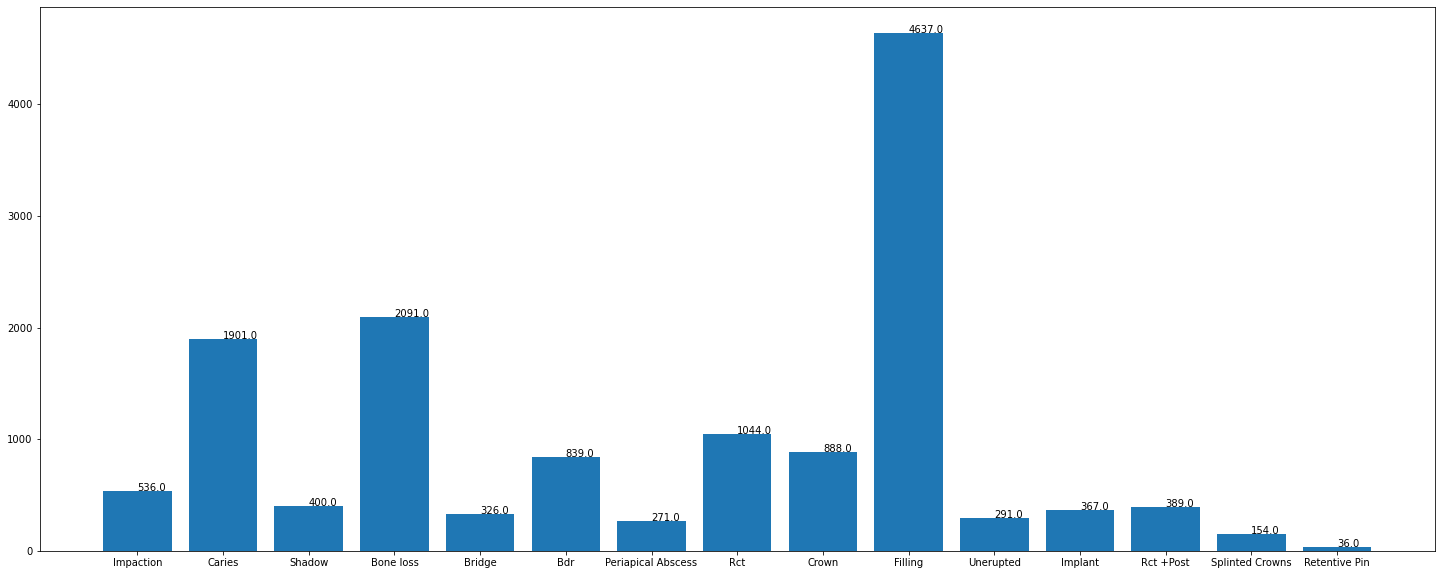

In [6]:



image_ids= dataset.image_ids
a1=[]
a2=[]
a3=[]
a4=[]
a5=[]
a6=[]
a7=[]
a8=[]
a9=[]
a10=[]
a11=[]
a12=[]
a13=[]
a14=[]
a15=[]
for id in image_ids:
    mask,class_ids=dataset.load_mask(id)
    a1=np.append(a1,np.count_nonzero(class_ids==1))
    a2=np.append(a2,np.count_nonzero(class_ids==2))
    a3=np.append(a3,np.count_nonzero(class_ids==3))
    a4=np.append(a4,np.count_nonzero(class_ids==4))
    a5=np.append(a5,np.count_nonzero(class_ids==5))
    a6=np.append(a6,np.count_nonzero(class_ids==6))
    a7=np.append(a7,np.count_nonzero(class_ids==7))
    a8=np.append(a8,np.count_nonzero(class_ids==8))
    a9=np.append(a9,np.count_nonzero(class_ids==9))
    a10=np.append(a10,np.count_nonzero(class_ids==10))
    a11=np.append(a11,np.count_nonzero(class_ids==11))
    a12=np.append(a12,np.count_nonzero(class_ids==12))
    a13=np.append(a13,np.count_nonzero(class_ids==13))
    a14=np.append(a14,np.count_nonzero(class_ids==14))
    a15=np.append(a15,np.count_nonzero(class_ids==15))

a1=np.sum(a1) #impaction
a2=np.sum(a2) #caries
a3=np.sum(a3) #shadow
a4=np.sum(a4) #bone loss
a5=np.sum(a5) # bridge
a6=np.sum(a6) #bdr
a7=np.sum(a7) #periapical
a8=np.sum(a8) #rct
a9=np.sum(a9) #crown
a10=np.sum(a10) #filling
a11=np.sum(a11)
a12=np.sum(a12)
a13=np.sum(a13)
a14=np.sum(a14)
a15=np.sum(a15)

a=[a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15]
class_names=['Impaction',
 'Caries',
 'Shadow',
 'Bone loss',
 'Bridge',
 'Bdr',
 'Periapical Abscess',
 'Rct',
 'Crown',
 'Filling',
 'Unerupted',
 'Implant',
 'Rct +Post','Splinted Crowns','Retentive Pin']

fig, ax = plt.subplots(figsize=(25,10))


plt.bar(class_names,a)
addlabels(class_names,a)

In [5]:
dataset = CustomDataset()
dataset.load_custom(r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\diagnosis_2.0\dataset",r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\diagnosis_2.0\dataset\val\val.json", "val")
dataset.prepare()

objects: ['Bone Loss']
numids [4]
1
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Caries', 'Filling', 'Bone Loss', 'Filling', 'Bone Loss', 'Filling', 'Filling', 'Bone Loss']
numids [10, 10, 10, 10, 10, 10, 10, 10, 2, 10, 4, 10, 4, 10, 10, 4]
2
objects: ['Bone Loss', 'Bone Loss']
numids [4, 4]
3
objects: ['Rct +Post', 'Rct +Post', 'Rct +Post', 'Rct +Post', 'Rct', 'Rct', 'Filling', 'Crown', 'Crown', 'Crown', 'Crown', 'Crown', 'Filling', 'Crown', 'Bridge', 'Bridge', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss', 'Filling', 'Rct', 'Filling']
numids [13, 13, 13, 13, 8, 8, 10, 9, 9, 9, 9, 9, 10, 9, 5, 5, 10, 10, 4, 4, 10, 8, 10]
4
objects: ['Rct', 'Unerupted', 'Unerupted', 'Unerupted', 'Filling', 'Filling', 'Filling']
numids [8, 11, 11, 11, 10, 10, 10]
5
objects: ['Unerupted', 'Unerupted', 'Unerupted', 'Unerupted']
numids [11, 11, 11, 11]
6
objects: ['Filling', 'Crown', 'Filling', 'Filling', 'Filling', 'Bone Loss']
numids [10, 9, 10, 10, 

55
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Caries', 'Caries', 'Caries', 'Caries', 'Caries', 'Caries', 'Bone Loss', 'Caries', 'Caries', 'Caries']
numids [10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2]
56
objects: ['Crown', 'Rct', 'Filling', 'Filling', 'Filling', 'Filling', 'Caries', 'Bone Loss', 'Caries', 'Filling']
numids [9, 8, 10, 10, 10, 10, 2, 4, 2, 10]
57
objects: ['Bridge', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Rct']
numids [5, 10, 10, 10, 10, 10, 8]
58
objects: ['Crown', 'Implant', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss', 'Bone Loss']
numids [9, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 4, 4]
59
objects: ['Bone Loss', 'Caries', 'Caries']
numids [4, 2, 2]
60
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bdr', 'Caries', 'Caries', 'Bdr'

objects: ['Filling', 'Caries', 'Filling', 'Filling', 'Bone Loss', 'Filling']
numids [10, 2, 10, 10, 4, 10]
106
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss']
numids [10, 10, 10, 10, 10, 4]
107
objects: ['Filling', 'Crown', 'Bone Loss', 'Bone Loss']
numids [10, 9, 4, 4]
108
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Crown', 'Rct', 'Bone Loss', 'Bone Loss']
numids [10, 10, 10, 10, 10, 9, 8, 4, 4]
109
objects: ['Crown', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss']
numids [9, 10, 10, 10, 4, 4]
110
objects: ['Crown', 'Crown', 'Bone Loss', 'Bone Loss']
numids [9, 9, 4, 4]
111
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss']
numids [10, 10, 10, 10, 10, 4]
112
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss', 'Bone Loss']
numids [10, 10, 10, 10, 4, 4, 4]
113
objects: ['Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss']
numids [10, 10, 10, 4, 4]
114
objects: ['Fi

objects: ['Filling', 'Filling', 'Filling', 'Bone Loss']
numids [10, 10, 10, 4]
178
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss']
numids [10, 10, 10, 10, 4, 4]
179
objects: ['Filling', 'Filling', 'Filling', 'Filling']
numids [10, 10, 10, 10]
180
objects: ['Filling', 'Filling', 'Filling', 'Rct']
numids [10, 10, 10, 8]
181
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss', 'Filling']
numids [10, 10, 10, 10, 4, 4, 10]
182
objects: ['Crown', 'Filling', 'Filling', 'Filling', 'Caries', 'Caries', 'Filling']
numids [9, 10, 10, 10, 2, 2, 10]
183
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss', 'Retentive Pin', 'Crown']
numids [10, 10, 10, 10, 10, 10, 4, 4, 15, 9]
184
objects: ['Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss']
numids [10, 10, 10, 10, 10, 10, 4]
185
objects: ['Crown', 'Filling', 'Filling', 'Filling', 'Rct', 'Bone Loss', 'Bone Loss']
numid

objects: ['Filling', 'Filling', 'Filling', 'Retentive Pin', 'Retentive Pin', 'Bone Loss', 'Bone Loss', 'Filling']
numids [10, 10, 10, 15, 15, 4, 4, 10]
256
objects: ['Crown', 'Crown', 'Crown', 'Filling', 'Filling', 'Caries', 'Filling', 'Caries', 'Bone Loss', 'Bone Loss', 'Caries']
numids [9, 9, 9, 10, 10, 2, 10, 2, 4, 4, 2]
257
objects: ['Crown', 'Rct', 'Caries']
numids [9, 8, 2]
258
objects: ['Filling']
numids [10]
259
objects: ['Filling', 'Filling', 'Filling', 'Caries', 'Bone Loss', 'Bone Loss', 'Bone Loss']
numids [10, 10, 10, 2, 4, 4, 4]
260
objects: ['Rct', 'Filling', 'Filling', 'Filling', 'Filling', 'Filling', 'Bone Loss']
numids [8, 10, 10, 10, 10, 10, 4]
261
objects: ['Caries', 'Caries', 'Filling', 'Filling', 'Filling', 'Filling', 'Caries', 'Filling', 'Filling', 'Bone Loss']
numids [2, 2, 10, 10, 10, 10, 2, 10, 10, 4]
262
objects: ['Bridge', 'Filling', 'Filling', 'Caries', 'Filling', 'Filling', 'Bone Loss', 'Bone Loss']
numids [5, 10, 10, 2, 10, 10, 4, 4]
263
objects: ['Splinte

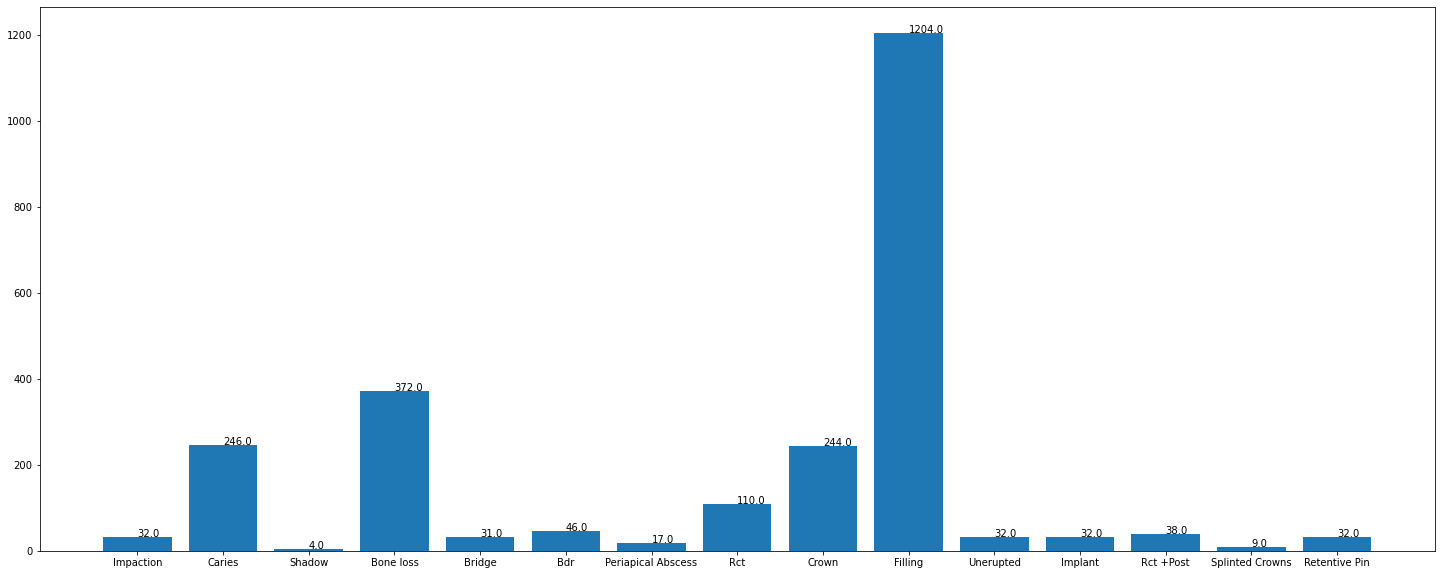

In [8]:


image_ids= dataset.image_ids
a1=[]
a2=[]
a3=[]
a4=[]
a5=[]
a6=[]
a7=[]
a8=[]
a9=[]
a10=[]
a11=[]
a12=[]
a13=[]
a14=[]
a15=[]
for id in image_ids:
    mask,class_ids=dataset.load_mask(id)
    a1=np.append(a1,np.count_nonzero(class_ids==1))
    a2=np.append(a2,np.count_nonzero(class_ids==2))
    a3=np.append(a3,np.count_nonzero(class_ids==3))
    a4=np.append(a4,np.count_nonzero(class_ids==4))
    a5=np.append(a5,np.count_nonzero(class_ids==5))
    a6=np.append(a6,np.count_nonzero(class_ids==6))
    a7=np.append(a7,np.count_nonzero(class_ids==7))
    a8=np.append(a8,np.count_nonzero(class_ids==8))
    a9=np.append(a9,np.count_nonzero(class_ids==9))
    a10=np.append(a10,np.count_nonzero(class_ids==10))
    a11=np.append(a11,np.count_nonzero(class_ids==11))
    a12=np.append(a12,np.count_nonzero(class_ids==12))
    a13=np.append(a13,np.count_nonzero(class_ids==13))
    a14=np.append(a14,np.count_nonzero(class_ids==14))
    a15=np.append(a15,np.count_nonzero(class_ids==15))

a1=np.sum(a1) #impaction
a2=np.sum(a2) #caries
a3=np.sum(a3) #shadow
a4=np.sum(a4) #bone loss
a5=np.sum(a5) # bridge
a6=np.sum(a6) #bdr
a7=np.sum(a7) #periapical
a8=np.sum(a8) #rct
a9=np.sum(a9) #crown
a10=np.sum(a10) #filling
a11=np.sum(a11) #unerupted
a12=np.sum(a12) #implant
a13=np.sum(a13) #rct + post
a14=np.sum(a14) # splinted crowns
a15=np.sum(a15) #retentive pin

a=[a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15]
class_names=['Impaction',
 'Caries',
 'Shadow',
 'Bone loss',
 'Bridge',
 'Bdr',
 'Periapical Abscess',
 'Rct',
 'Crown',
 'Filling',
 'Unerupted',
 'Implant',
 'Rct +Post','Splinted Crowns','Retentive Pin']
fig, ax = plt.subplots(figsize=(25,10))
plt.bar(class_names,a)
addlabels(class_names,a)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  5
the actual len of the pred vect is :  5
Average precision of this image :  1.0
The actual mean average precision for the whole images (matterport methode)  1.0
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
th

the actual len of the gt vect is :  242
the actual len of the pred vect is :  242
Average precision of this image :  0.4285714328289032
The actual mean average precision for the whole images (matterport methode)  0.6877054465621207
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  250
the actual len of the pred vect is :  250
Average precision of this image :  0.3333333333333333
The actual mean average precision for the whole images (matterport methode)  0.664080639013535
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images          

the actual len of the gt vect is :  558
the actual len of the pred vect is :  558
Average precision of this image :  0.43936652874245363
The actual mean average precision for the whole images (matterport methode)  0.683957547074108
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  232.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  128.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  576
the actual len of the pred vect is :  576
Average precision of this image :  0.7272727489471436
The actual mean average precision for the whole images (matterport methode)  0.6855045185695736
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images         

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  833
the actual len of the pred vect is :  833
Average precision of this image :  0.9027777959903082
The actual mean average precision for the whole images (matterport methode)  0.6893934305188426
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  1121
the actual len of the pred vect is :  1121
Average precision of this image :  0.5041322464292699
The actual mean average precision for the whole images (matterport methode)  0.6564329945672582
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -

the actual len of the gt vect is :  1398
the actual len of the pred vect is :  1398
Average precision of this image :  0.7320842125874046
The actual mean average precision for the whole images (matterport methode)  0.6636027123557278
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  1409
the actual len of the pred vect is :  1409
Average precision of this image :  1.0
The actual mean average precision for the whole images (matterport methode)  0.6685497312916729
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (

the actual len of the gt vect is :  1674
the actual len of the pred vect is :  1674
Average precision of this image :  0.6666666865348816
The actual mean average precision for the whole images (matterport methode)  0.6883431615820325
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  1702
the actual len of the pred vect is :  1702
Average precision of this image :  0.5366666883230209
The actual mean average precision for the whole images (matterport methode)  0.6864706125294521
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images     

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  1954
the actual len of the pred vect is :  1954
Average precision of this image :  0.7719298245614035
The actual mean average precision for the whole images (matterport methode)  0.6979369370030107
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  2212
the actual len of the pred vect is :  2212
Average precision of this image :  0.7380952239036561
The actual mean average precision for the whole images (matterport methode)  0.6879823838321966
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -

the actual len of the gt vect is :  2501
the actual len of the pred vect is :  2501
Average precision of this image :  0.6130952512224516
The actual mean average precision for the whole images (matterport methode)  0.6859472291433861
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  2518
the actual len of the pred vect is :  2518
Average precision of this image :  0.875
The actual mean average precision for the whole images (matterport methode)  0.6875096487372425
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape:

the actual len of the gt vect is :  2826
the actual len of the pred vect is :  2826
Average precision of this image :  0.5075922730105995
The actual mean average precision for the whole images (matterport methode)  0.6815564856538124
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  2844
the actual len of the pred vect is :  2844
Average precision of this image :  0.7158333363632361
The actual mean average precision for the whole images (matterport methode)  0.6818122830471663
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images     

the actual len of the gt vect is :  3100
the actual len of the pred vect is :  3100
Average precision of this image :  0.852777786552906
The actual mean average precision for the whole images (matterport methode)  0.6828432129170563
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  3111
the actual len of the pred vect is :  3111
Average precision of this image :  0.6666666865348816
The actual mean average precision for the whole images (matterport methode)  0.6827331685198986
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images      

the actual len of the gt vect is :  3321
the actual len of the pred vect is :  3321
Average precision of this image :  1.0
The actual mean average precision for the whole images (matterport methode)  0.6892372118601804
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  3342
the actual len of the pred vect is :  3342
Average precision of this image :  0.60238097012043
The actual mean average precision for the whole images (matterport methode)  0.688694360349307
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 

anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  3603
the actual len of the pred vect is :  3603
Average precision of this image :  0.85
The actual mean average precision for the whole images (matterport methode)  0.6979673438079563
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  3622
the actual len of the pred vect is :  3622
Average precision of this image :  0.904761906181063
The actual mean average precision for the whole images (matterport methode)  0.6991558183043535
Processing 1 images
image                    shape:

the actual len of the gt vect is :  3847
the actual len of the pred vect is :  3847
Average precision of this image :  0.8145604506134987
The actual mean average precision for the whole images (matterport methode)  0.6990034493977832
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  3862
the actual len of the pred vect is :  3862
Average precision of this image :  0.7333333492279053
The actual mean average precision for the whole images (matterport methode)  0.699187031749816
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images      

the actual len of the gt vect is :  4100
the actual len of the pred vect is :  4100
Average precision of this image :  1.0
The actual mean average precision for the whole images (matterport methode)  0.7081459352480027
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  4117
the actual len of the pred vect is :  4117
Average precision of this image :  0.48571429933820454
The actual mean average precision for the whole images (matterport methode)  0.7070393101937251
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: 

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  4376
the actual len of the pred vect is :  4376
Average precision of this image :  0.6628787788477811
The actual mean average precision for the whole images (matterport methode)  0.710708207400295
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0

the actual len of the gt vect is :  4654
the actual len of the pred vect is :  4654
Average precision of this image :  0.4000000059604645
The actual mean average precision for the whole images (matterport methode)  0.7081576412248302
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  4667
the actual len of the pred vect is :  4667
Average precision of this image :  1.0
The actual mean average precision for the whole images (matterport methode)  0.7094376515703352
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (

the actual len of the gt vect is :  4922
the actual len of the pred vect is :  4922
Average precision of this image :  0.44000001549720763
The actual mean average precision for the whole images (matterport methode)  0.7064929109323822
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  4942
the actual len of the pred vect is :  4942
Average precision of this image :  0.05357142936970506
The actual mean average precision for the whole images (matterport methode)  0.7037836931665619
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images   

the actual len of the gt vect is :  5218
the actual len of the pred vect is :  5218
Average precision of this image :  0.5161255408965406
The actual mean average precision for the whole images (matterport methode)  0.6981195799692055
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  5234
the actual len of the pred vect is :  5234
Average precision of this image :  0.8450000032782555
The actual mean average precision for the whole images (matterport methode)  0.6986978493523119
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images     

the actual len of the gt vect is :  5477
the actual len of the pred vect is :  5477
Average precision of this image :  0.29914530118306476
The actual mean average precision for the whole images (matterport methode)  0.6909385184951362
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  5502
the actual len of the pred vect is :  5502
Average precision of this image :  0.5000000186264515
The actual mean average precision for the whole images (matterport methode)  0.6902233930274633
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images    

the actual len of the gt vect is :  5800
the actual len of the pred vect is :  5800
Average precision of this image :  0.3717948794364929
The actual mean average precision for the whole images (matterport methode)  0.6810780212432892
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  5813
the actual len of the pred vect is :  5813
Average precision of this image :  1.0
The actual mean average precision for the whole images (matterport methode)  0.6822170283102774
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (

the actual len of the gt vect is :  6076
the actual len of the pred vect is :  6076
Average precision of this image :  1.0
The actual mean average precision for the whole images (matterport methode)  0.6810921721675967
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  6102
the actual len of the pred vect is :  6102
Average precision of this image :  0.5379188855489095
The actual mean average precision for the whole images (matterport methode)  0.6806051881995059
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  6361
the actual len of the pred vect is :  6361
Average precision of this image :  0.6000000238418579
The actual mean average precision for the whole images (matterport methode)  0.678236522840435
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11

the actual len of the gt vect is :  6665
the actual len of the pred vect is :  6665
Average precision of this image :  0.805555542310079
The actual mean average precision for the whole images (matterport methode)  0.6746071191491783
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  6689
the actual len of the pred vect is :  6689
Average precision of this image :  0.3333333333333333
The actual mean average precision for the whole images (matterport methode)  0.673543960937914
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images       

the actual len of the gt vect is :  6942
the actual len of the pred vect is :  6942
Average precision of this image :  1.0
The actual mean average precision for the whole images (matterport methode)  0.673457609703036
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
the actual len of the gt vect is :  6960
the actual len of the pred vect is :  6960
Average precision of this image :  0.8166666666666667
The actual mean average precision for the whole images (matterport methode)  0.6738850994253155
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1

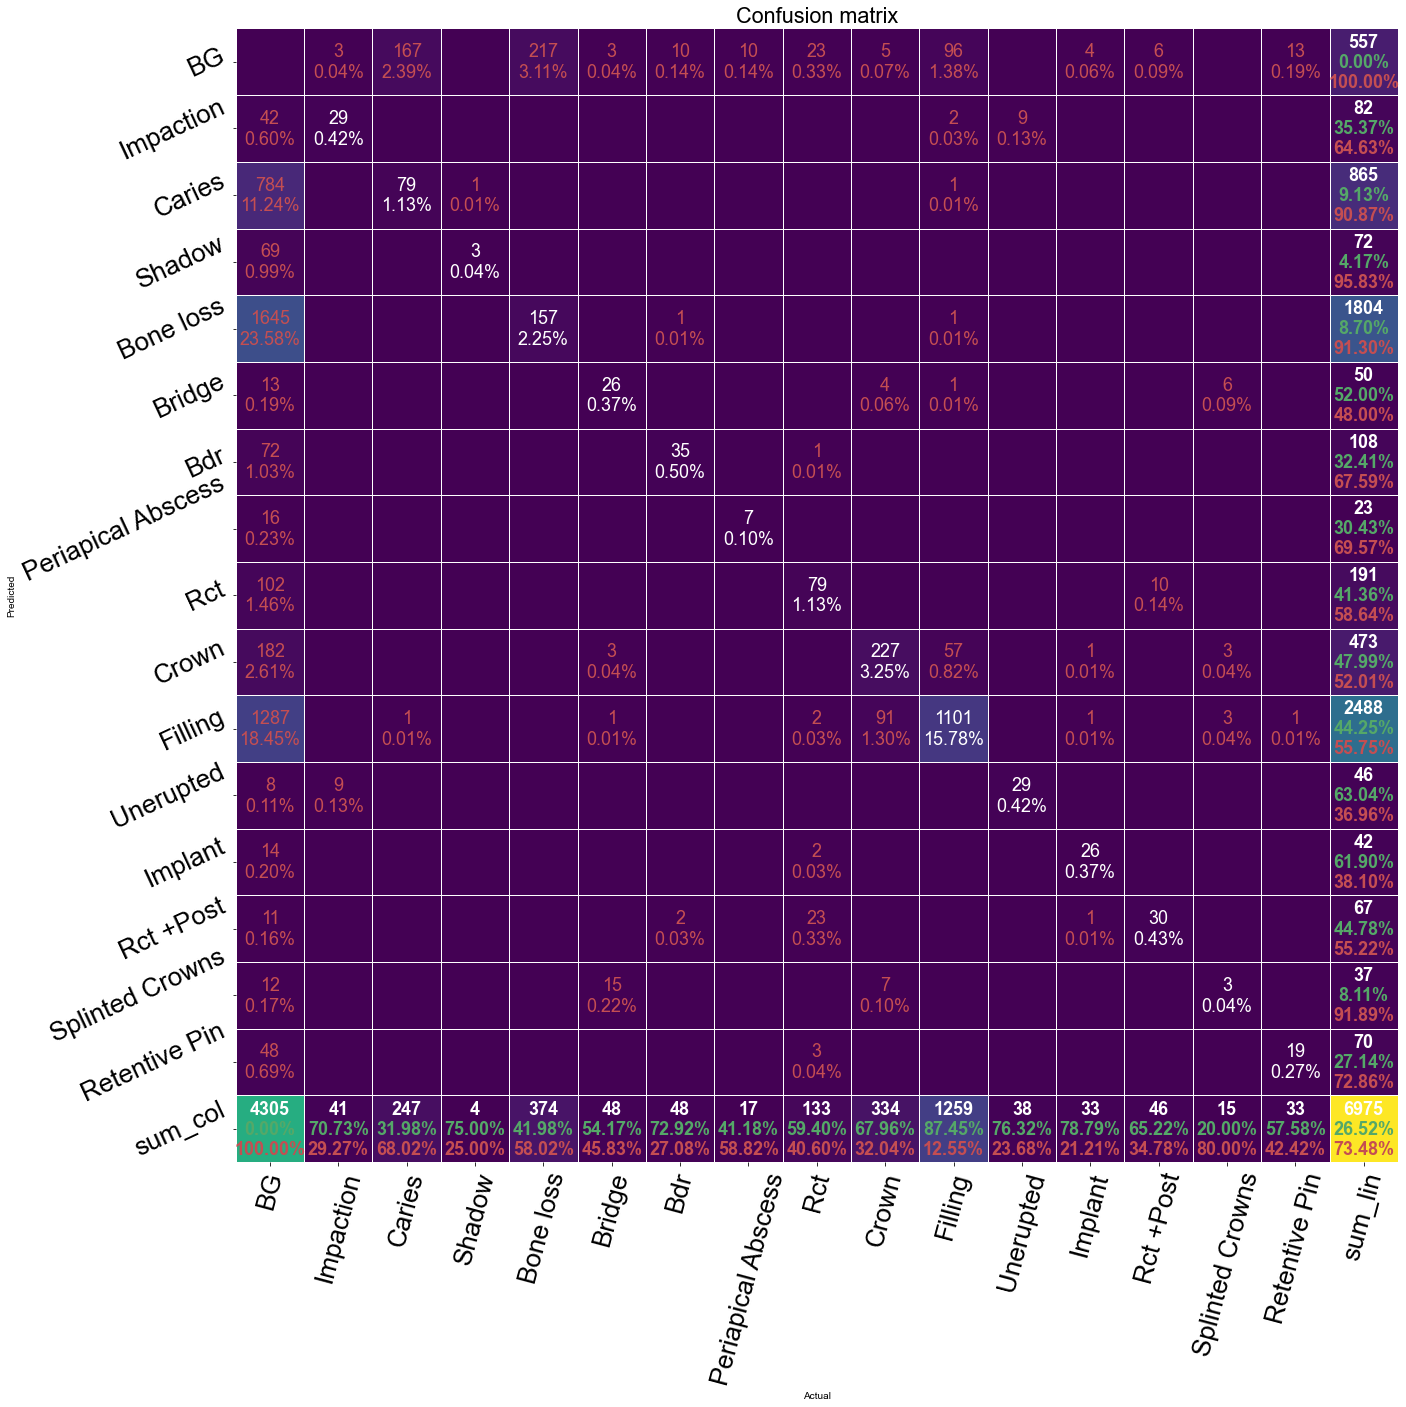

In [6]:
import pandas as pd
import numpy as np
import os 

#ground-truth and predictions lists
gt_tot = np.array([])
pred_tot = np.array([])
#mAP list
mAP_ = []

#compute gt_tot, pred_tot and mAP for each image in the test dataset
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset,  InferenceConfig, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'],iou_threshold=0.5)
    #check if the vectors len are equal
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images (matterport methode) ", sum(mAP_)/len(mAP_))
    #print("Ground truth object : "+dataset.class_names[gt])
    #print("Predicted object : "+dataset.class_names[pred])

gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))
    
#print the confusion matrix and compute true postives, false positives and false negative for each class: 
#ps : you can controle the figure size and text format by choosing the right values
tp, fp, fn,confusion = utils.plot_confusion_matrix_from_data(gt_tot, pred_tot, dataset.class_names, fz=18, figsize=(20,20), lw=0.5)

In [7]:
np.savetxt('confusion_matrix.txt', confusion, fmt='%d')

In [8]:
accuracy=[]
accuracy=confusion.diagonal()/confusion.sum(axis=1)
accuracy=accuracy.reshape([1,16])

df = pd.DataFrame(accuracy,columns=dataset.class_names)
df.to_csv('accuracy.txt', sep='\t', index=False)

In [11]:
values = []
current_value = 0.0

while current_value <= 1.0:
    values.append(current_value)
    current_value += 0.1

print(values)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999]


In [13]:
def compute_batch_ap(image_ids,iou_threshold):
    APs = []
    ARs=[]
    Precisions=[]
    #list_iou_thresholds = np.arange(0.5, 1.01, 0.1)

    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset,InferenceConfig,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'],iou_threshold)
        APs.append(AP)
        Precisions.append(precisions)
        AR,positive_ids = utils.compute_recall(r['rois'], gt_bbox,iou=iou_threshold)
        ARs.append(AR)
        #visualize.plot_precision_recall(AP, precisions, recalls)
    mAP=np.mean(APs)
    mAR=np.mean(ARs)
    F1=2 * ((mAP * mAR) / (mAP + mAR))
    #visualize.plot_precision_recall(mAP, precisions, recalls)
    return APs,ARs,F1,Precisions

# Pick a set of random images.


In [15]:
image_ids = dataset.image_ids
mAP=[]
for value in values:
    APs,ARs,F1,Precisions = compute_batch_ap(image_ids,value)
    mAP.append(np.mean(APs))
    




C:\Users\HP\.conda\envs\mrcnn4\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [16]:
print(mAP)

[0.8735437359066389, 0.7690120012566579, 0.751343877066086, 0.734213868687438, 0.7115398437704623, 0.6733675842484542, 0.609655735961378, 0.516651565500798, 0.3241955322550937, 0.04635447442887156, 0.0]


(0.0, 1.0)

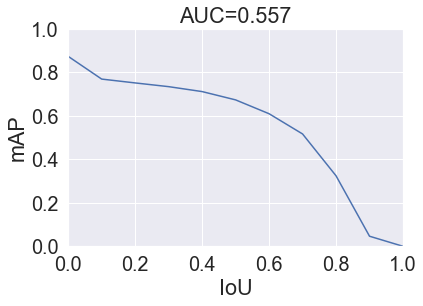

In [20]:
plt.plot(values, mAP)
plt.xlabel('IoU')
plt.ylabel('mAP')
plt.title('AUC=0.557')
plt.xlim(0, 1)
plt.ylim(0, 1)

In [18]:
auc=np.trapz(mAP, values)

In [19]:
print(auc)

0.5573106351128558
